<a href="https://colab.research.google.com/github/urbanik/DP/blob/main/raindrop%26insect_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next look at:

Why use validation 

https://machinelearningmastery.com/difference-test-validation-datasets/

Regularization & Dropout (useful when model overfits, instead of more data)

https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3

BatchNormalization

Imports

In [2]:
import torch, torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from torchsummary import summary

import numpy as np
from skimage import io
import pandas as pd
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time

In [3]:
!cp './drive/MyDrive/Colab Notebooks/DATA/ARIAS_images.zip' './ARIAS_images.zip'
!unzip -q -o './ARIAS_images.zip'
!rm -f './ARIAS_images.zip'

**Device**

What is cuda - https://www.infoworld.com/article/3299703/what-is-cuda-parallel-programming-for-gpus.html

Cuda is parallel computing platform and programming model 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Dataset**
Data transformation - different sizes of input pictures of adherent raindrops and insect

Creating batches of different sizes 
https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278

Custom dataset 
https://www.youtube.com/watch?v=ZoZHd0Zm3RY
Custam dataset on Google Colab
https://www.youtube.com/watch?v=b4R9WvfHs4M


Resizing
https://discuss.pytorch.org/t/does-resize-affect-image-details/86503


https://pytorch.org/docs/stable/torchvision/transforms.html

PIL resizing MODES 

https://pillow.readthedocs.io/en/3.0.0/reference/Image.html



In [5]:
#ARIAS - Adherent Raindrops, Insect And Sun
class ARIAS_dataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      img_PIL = transforms.ToPILImage()(image)
      img_PIL = transforms.Resize([100, 100])(img_PIL) # average width = 149 and height = 132 from dataset
      img = self.transform(img_PIL)
      
    
    return img, y_label

Dataset loading

In [6]:
dataset = ARIAS_dataset(csv_file='/content/drive/MyDrive/Colab Notebooks/DATA/ARIAS_labels.csv', root_dir='ARIAS_images', transform=transforms.ToTensor())
len(dataset)

6651

Data split

https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [7]:
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [3990, 1330, 1331]) # why? 60 - 20 -20

train_data_size = len(train_set)
valid_data_size = len(valid_set)







# Get a mapping of the indices to the class names, in order to see the output classes of the test images. -NOT WOKING YET
#idx_to_class = {v: k for k, v in train_set.class_to_idx.items()}
#print(idx_to_class)

# loaders
batch_size = 32
train_data_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(dataset=test_set, batch_size=1331, shuffle=False)

tensor(0)


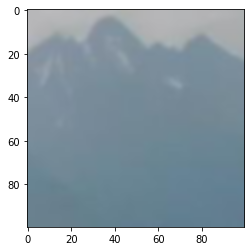

In [8]:
example = test_set[2]
print(example[1])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Data classes

In [9]:
classes = ['nothing', 'raindrop', 'insect', 'sun']

ALEXNET
https://www.youtube.com/watch?v=8etkVC93yU4

In [10]:
AlexNet = models.alexnet(pretrained=True)
AlexNet#freezing parameters
for param in AlexNet.parameters():
  param.requires_grad = False


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


TRANSFER LEARNING

The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. For object recognition with a CNN, we freeze the early convolutional layers of the network and only train the last few layers which make a prediction.

https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Example of implementation -
https://www.youtube.com/watch?v=8etkVC93yU4

Github - https://github.com/madsendennis/notebooks/blob/master/pytorch/3_PyTorch_Transfer_learning.ipynb 

Similar work - https://github.com/GTC7788/raindropDetection

https://github.com/tobybreckon/raindrop-detection-cnn

In [11]:
#freezing parameters - TRANSFERLEARNING
for param in AlexNet.parameters():
  param.requires_grad = False


In [12]:
#change of the final layer of AlexNet model 
AlexNet.classifier[6] = nn.Linear(4096, 4) # we have 4 classes already
AlexNet.classifier.add_module("7", nn.LogSoftmax(dim=1))
AlexNet.to(device) # in case we use GPU

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Loss function
NLLLoss - https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

Loss functions in PyTorch - https://heartbeat.fritz.ai/the-right-loss-function-pytorch-58d2c0d77404

Loss dunction crossentropyloss (combination of logSoftmax and NLLLoss) - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
Cross-validation - https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29


In [13]:
loss_func = nn.CrossEntropyLoss()

Optimizer

In [14]:
optimizer = optim.Adam(AlexNet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Train and validate function

In [15]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
  start = time.time()
  history = []
  best_acc = 0.0
  best_model = None
  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_data_loader):

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # clean existing gradients

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)
      
      # Compute loss
      loss = loss_criterion(outputs, labels)
      
      # Backpropagate the gradients
      loss.backward()
      
      # Update the parameters
      optimizer.step()
      
      # Compute the total loss for the batch and add it to train_loss
      train_loss += loss.item() * inputs.size(0)
      
      # Compute the accuracy
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))
      
      # Convert correct_counts to float and then compute the mean
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      
      # Compute total accuracy in the whole batch and add to train_acc
      train_acc += acc.item() * inputs.size(0)
    # Validation - No gradient tracking needed
    with torch.no_grad():

      # Set to evaluation mode
      model.eval()

      # Validation loop
      for j, (inputs, labels) in enumerate(valid_data_loader):
          inputs = inputs.to(device) # cuda or cpu
          labels = labels.to(device)

          # Forward pass - compute outputs on input data using the model
          outputs = model(inputs)

          # Compute loss
          loss = loss_criterion(outputs, labels)

          # Compute the total loss for the batch and add it to valid_loss
          valid_loss += loss.item() * inputs.size(0)

          # Calculate validation accuracy
          ret, predictions = torch.max(outputs.data, 1)
          correct_counts = predictions.eq(labels.data.view_as(predictions))

          # Convert correct_counts to float and then compute the mean
          acc = torch.mean(correct_counts.type(torch.FloatTensor))

          # Compute total accuracy in the whole batch and add to valid_acc
          valid_acc += acc.item() * inputs.size(0)
          
          print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
      
    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size 
    avg_train_acc = train_acc/train_data_size

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size 
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
            
    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    
    # Save if the model has best accuracy till now
    if best_acc < avg_valid_acc:
      best_acc = avg_valid_acc
      best_model = model
    
    #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
          
  return best_acc, best_model, history      

Train and validation into graph


In [16]:
num_epochs = 20
acc, trained_model, history = train_and_validate(AlexNet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/20
Validation Batch number: 000, Validation: Loss: 0.2843, Accuracy: 0.9062
Validation Batch number: 001, Validation: Loss: 0.3080, Accuracy: 0.9062
Validation Batch number: 002, Validation: Loss: 0.3507, Accuracy: 0.9375
Validation Batch number: 003, Validation: Loss: 0.2630, Accuracy: 0.9688
Validation Batch number: 004, Validation: Loss: 0.2701, Accuracy: 0.9062
Validation Batch number: 005, Validation: Loss: 0.4484, Accuracy: 0.8438
Validation Batch number: 006, Validation: Loss: 0.2982, Accuracy: 0.8438
Validation Batch number: 007, Validation: Loss: 0.3217, Accuracy: 0.9062
Validation Batch number: 008, Validation: Loss: 0.3266, Accuracy: 0.8125
Validation Batch number: 009, Validation: Loss: 0.2719, Accuracy: 0.9062
Validation Batch number: 010, Validation: Loss: 0.3468, Accuracy: 0.9062
Validation Batch number: 011, Validation: Loss: 0.1559, Accuracy: 0.9375
Validation Batch number: 012, Validation: Loss: 0.1277, Accuracy: 0.9375
Validation Batch number: 013, Validatio

In [17]:
print(acc)

0.9157894736842105


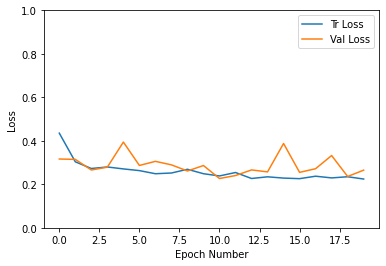

In [18]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

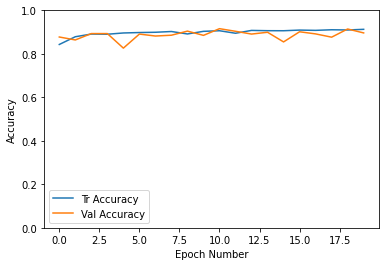

In [19]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

Prediction function


In [20]:
def predict(model, image):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    img_PIL = transforms.ToPILImage()(image)
    img_PIL = transforms.Resize([100, 100])(img_PIL)
    test_image_tensor = transforms.ToTensor()(img_PIL)
    test_image_tensor = test_image_tensor.view(1, 3, 100, 100)
    test_image_tensor = test_image_tensor.to(device)# in case we use GPU

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(len(classes), dim=1)
        for i in range(len(classes)):
            topk, topclass = topk.cpu(), topclass.cpu()# in case we use GPU
            print("Predcition", i+1, ":", classes[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i]) #idx_to_class[topclass.numpy()[0][i]]

Test on some examples of test data

Predcition 1 : nothing , Score:  0.98332995
Predcition 2 : raindrop , Score:  0.015134726
Predcition 3 : insect , Score:  0.0011827043
Predcition 4 : sun , Score:  0.00035265717
Actual: nothing


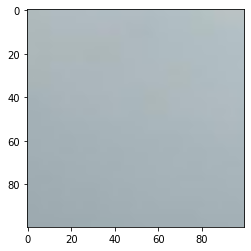

In [21]:
example = test_set[0]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.92958593
Predcition 2 : raindrop , Score:  0.06565186
Predcition 3 : insect , Score:  0.003920873
Predcition 4 : sun , Score:  0.00084129773
Actual: nothing


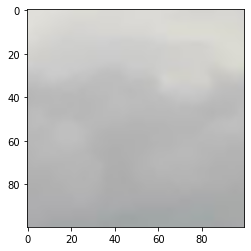

In [22]:
example = test_set[1]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.94862133
Predcition 2 : raindrop , Score:  0.047813512
Predcition 3 : insect , Score:  0.0032707737
Predcition 4 : sun , Score:  0.00029445384
Actual: nothing


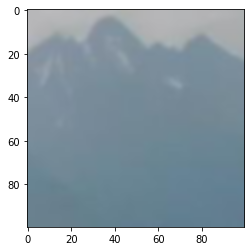

In [23]:
example = test_set[2]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.99197394
Predcition 2 : raindrop , Score:  0.007740348
Predcition 3 : insect , Score:  0.00028565802
Predcition 4 : sun , Score:  7.592437e-12
Actual: nothing


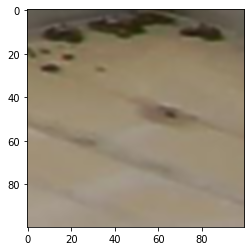

In [24]:
example = test_set[3]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.99870646
Predcition 2 : raindrop , Score:  0.0011065174
Predcition 3 : insect , Score:  0.00018698303
Predcition 4 : sun , Score:  1.2809995e-11
Actual: nothing


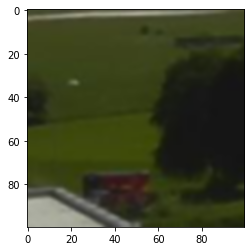

In [25]:
example = test_set[4]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.99846214
Predcition 2 : raindrop , Score:  0.0014722876
Predcition 3 : insect , Score:  4.947583e-05
Predcition 4 : sun , Score:  1.6033831e-05
Actual: nothing


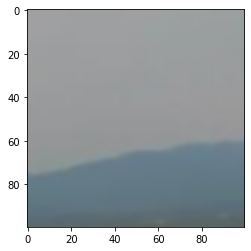

In [26]:
example = test_set[5]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.99996305
Predcition 2 : raindrop , Score:  3.6992413e-05
Predcition 3 : insect , Score:  1.023796e-08
Predcition 4 : sun , Score:  3.017611e-15
Actual: nothing


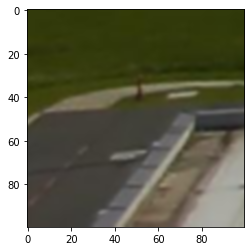

In [27]:
example = test_set[6]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.99844104
Predcition 2 : raindrop , Score:  0.0015466464
Predcition 3 : insect , Score:  1.23814325e-05
Predcition 4 : sun , Score:  9.617999e-10
Actual: nothing


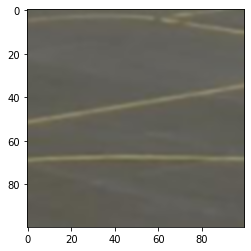

In [28]:
example = test_set[7]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : raindrop , Score:  0.9350316
Predcition 2 : nothing , Score:  0.06364706
Predcition 3 : insect , Score:  0.0013213468
Predcition 4 : sun , Score:  1.9332744e-09
Actual: raindrop


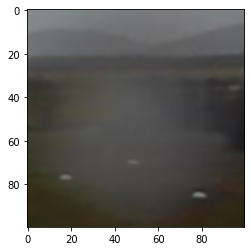

In [29]:
example = test_set[8]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

Predcition 1 : nothing , Score:  0.9999699
Predcition 2 : insect , Score:  3.0040563e-05
Predcition 3 : raindrop , Score:  7.416729e-08
Predcition 4 : sun , Score:  1.1581517e-12
Actual: nothing


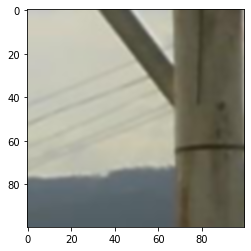

In [30]:
example = test_set[9]
predict(trained_model, example[0])
print("Actual:", classes[example[1]])
plt.imshow(transforms.ToPILImage()(example[0]), interpolation="bicubic")

In [31]:
def predict_on_testset(model):
  for j, (inputs, labels) in enumerate(test_data_loader):
    inputs = inputs.to(device) # cuda or cpu
    labels = labels.to(device)

    # Forward pass - compute outputs on input data using the model
    outputs = model(inputs)

    # Calculate validation accuracy
    ret, predictions = torch.max(outputs.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))

    # Convert correct_counts to float and then compute the mean
    acc = torch.mean(correct_counts.type(torch.FloatTensor))

    # Compute total accuracy in the whole batch and add to valid_acc
    #test_acc += acc.item() * inputs.size(0)
    
  print("Test accuracy: {:.4f}".format(acc.item()))
  return predictions, labels

In [32]:
predictions, labels = predict_on_testset(trained_model)

Test accuracy: 0.9174


Confusion matrix

https://en.wikipedia.org/wiki/Confusion_matrix

PyTorch confusion matrix - https://deeplizard.com/learn/video/0LhiS6yu2qQ


In [33]:
print(predictions.shape)

torch.Size([1331])


In [34]:
print(labels.shape)

torch.Size([1331])


In [35]:
# stack
stacked_labels_and_predictions = torch.stack((labels, predictions),dim=1)
stacked_labels_and_predictions.shape

torch.Size([1331, 2])

In [36]:
stacked_labels_and_predictions

tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [1, 1],
        [1, 1],
        [2, 2]], device='cuda:0')

In [37]:
n_classes = 4 # nothing, raindrop, insect, sun
conf_mtrx = torch.zeros(n_classes, n_classes, dtype=torch.int64)
conf_mtrx

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [38]:
for p in stacked_labels_and_predictions:
    tl, pl = p.tolist()
    conf_mtrx[tl, pl] = conf_mtrx[tl, pl] + 1

conf_mtrx

tensor([[941,  19,   5,   0],
        [ 57, 173,  24,   0],
        [  1,   4,  80,   0],
        [  0,   0,   0,  27]])

In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_mtrx, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        conf_mtrx = conf_mtrx.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_mtrx)
    plt.imshow(conf_mtrx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_mtrx.max() / 2.
    for i, j in itertools.product(range(conf_mtrx.shape[0]), range(conf_mtrx.shape[1])):
        plt.text(j, i, format(conf_mtrx[i, j], fmt), horizontalalignment="center", color="white" if conf_mtrx[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[941,  19,   5,   0],
        [ 57, 173,  24,   0],
        [  1,   4,  80,   0],
        [  0,   0,   0,  27]])


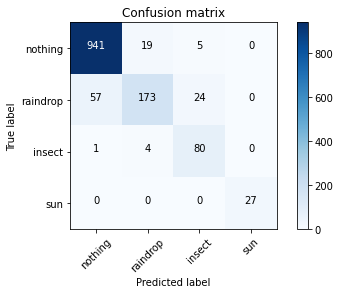

In [40]:
classes = ['nothing', 'raindrop', 'insect', 'sun']

plot_confusion_matrix(conf_mtrx=conf_mtrx, classes=classes)

true positive (TP)
    eqv. with hit

true negative (TN)
    eqv. with correct rejection

false positive (FP)
    eqv. with false alarm, Type I error
    
false negative (FN)
    eqv. with miss, Type II error